In [1]:
import mesa
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import time
import os

from Model_Ilya_Play_Area import *

### Batch Simulations

#### Self written batch run function for predator prey model

In [2]:
def batch_run(num_type_a_1, num_type_a_2, is_torus, grid_dim, immediate_killing, aggressiveness, steps_number, iterations_per_condition):
    # inputs have have to be lists

    # Create all possible combinations of initial conditions
    initial_conditions = itertools.product(num_type_a_1, num_type_a_2, is_torus, grid_dim, immediate_killing, aggressiveness, steps_number, iterations_per_condition)
    
    output = {}
    counter = 0

    for i in initial_conditions:

        start_time = time.time()

        # Unpack each initial consition into separate varibales
        n_a1, n_a2, torus, grid, im_killing, aggr, steps_number, iteration = i

        # Start the simulation
        model = Microbiome(n_a1, n_a2, torus, grid, grid, immediate_killing = im_killing, aggressiveness = aggr)
        for s in range(steps_number):
            model.step()
        
        # Collect the data
        agent_num_data = model.datacollector.get_model_vars_dataframe()
        num_of_agents_1 = agent_num_data.loc[:,"Type_a_1"]
        num_of_agents_2 = agent_num_data.loc[:,"Type_a_2"]

        end_time = time.time()
        run_time = (end_time - start_time) / 60

        output[i] = [run_time, num_of_agents_1, num_of_agents_2]
        
        counter += 1
        print(f"Iteration {counter} done; run time: {run_time}.")

    # Output is a dictionary where each key is the combination of the intial conditions variables and the entry is a list containing runtime, number of predators and number of preys
    return output

In [3]:
# Input for the batch run function
a1 = [5]
a2 = [35]
torus = [False]
grid = [25]
i_kill = [False]
aggress = [0.01]
max_steps = [750]
iterations = 30

iterations_input = list(range(1,1+iterations))

# Calling the function
results = batch_run(a1, a2, torus, grid, i_kill, aggress, max_steps, iterations_input)

Iteration 1 done; run time: 42.86835451126099.
Iteration 2 done; run time: 50.972995833555856.


In [ ]:
#Takes the results dictionary, displays every batch run as a graph and saves summary about the batch into a csv file
def create_batch_report(results_dictionary): 

    iterations = list(results_dictionary.keys())
    steady_state = []
    dominator = []

    for i in iterations:
    
        run_data = results[i]
        run_time, n_predator, n_prey, time_steps = run_data[0], run_data[1], run_data[2], run_data[1].index

        plt.plot(time_steps, n_predator, label = "Predator")
        plt.plot(time_steps, n_prey, label = "Prey")

    # Adding labels and title
        plt.legend()
        plt.xlabel('Time Step')
        plt.ylabel('Number of Agents')
        plt.title(f"Initial conditions: {i}; run time: {np.round(run_time)} mins")

        # Displaying the plot
        plt.show()

        if n_predator.iloc[-1] > 0 and n_prey.iloc[-1] > 0:
            steady_state.append(True)
            dominator.append(None)

        else:
            steady_state.append(False)

            if n_predator.iloc[-1] > 0:
                dominator.append("Predator")
            
            else:
                dominator.append("Prey")
    
    summary = {
        "Steady State" : steady_state,
        "Dominator" : dominator
    }
    summary_df = pd.DataFrame(summary)
    file_path = os.path.join(os.getcwd(), "Batch_runs", f"{iterations[0]}.csv")
    summary_df.to_csv(file_path)

In [ ]:
# Calling the function to display the graphs and save csv report
create_batch_report(results)

### Trying new features of the model

#### Simulate both populations

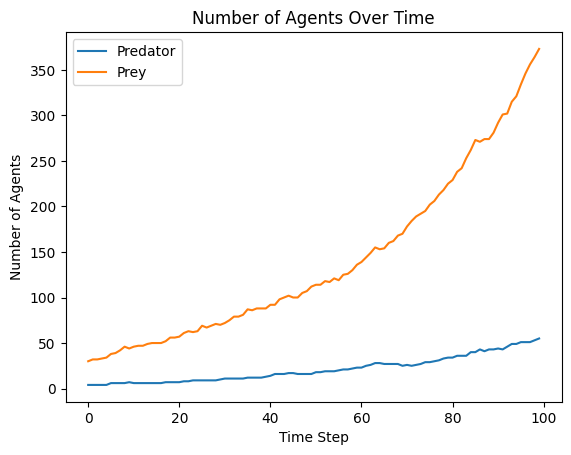

In [38]:
#Making x steps with in the model
x = 100

model = Microbiome(4, 30, False, 25, 25, immediate_killing = False, aggressiveness = 0.01)
for i in range(x):
    model.step()

# Check the numbers of agents

agent_num_data = model.datacollector.get_model_vars_dataframe()
num_of_agents_1 = agent_num_data.loc[:,"Type_a_1"]
num_of_agents_2 = agent_num_data.loc[:,"Type_a_2"]
number_of_time_steps = agent_num_data.index

# Plotting the number of agents over time
plt.plot(number_of_time_steps, num_of_agents_1, label = "Predator")
plt.plot(number_of_time_steps, num_of_agents_2, label = "Prey")

# Adding labels and title
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Number of Agents')
plt.title('Number of Agents Over Time')

# Displaying the plot
plt.show()

#### Simulate single population

In [ ]:
#Making x steps with in the model
x = 300

model = Microbiome(0,10, False, 10, 10, immediate_killing = False)
for i in range(x):
    model.step()

# Check the numbers of agents

agent_num_data = model.datacollector.get_model_vars_dataframe()
num_of_agents = agent_num_data.loc[:,"Type_a_2"]
number_of_time_steps = agent_num_data.index

# Plotting the number of agents over time
plt.plot(number_of_time_steps, num_of_agents)

# Adding labels and title
plt.xlabel('Time Step')
plt.ylabel('Number of Agents')
plt.title('Number of Agents Over Time')

# Displaying the plot
plt.show()

In [10]:
# interseting trend that increase in max colony radius does not necesarrily increase the simulation runtime
# TO DO:
# DONE 1. Check the variables of the bacteria for artefacts, single type 
# DONE 2. Run the simulation in the browser, single type
# DONE 3. Compare spread with one starting bacteria with and without the recursive function, both starting points somewhere in the middle, 50 x 50 grid
### Recursive: 313 steps, non recursive: ~ 1k steps
# DONE 4. Adapt Type 1 accordingly
# DONE 5. Run the simulation in the browser, both types
### Issue (solved): Predator expands randomly in two microcolonies of Prey 

### Issue: The max number of bacteria per simulation coordinate is exceeded in some cases
### Issue: Smulation is too slow once the entire grid is full
### Idea: introduce a feature that modifies microcolony growth when the max cell count is reached
# DONE 6. Review secretion of antibiotica and the stress reaction
# 7. Do final artifact checking


In [7]:
s_mutens_radius = 0.75 # micrometers
average_bacteria_area = 4*math.pi*s_mutens_radius**2 
average_bacteria_area

7.0685834705770345

In [9]:
# Extract the data about mass of one of the bacteria
my_variable_view = []

my_agents = [agent for agent in model.schedule.agents if isinstance(agent, Type_a_2)]
for agent in my_agents:

    # Acess the variables of the current agent
    my_variable_view.append(agent.area)

    #print(f"{agent.unique_id}:{my_vars}")
    # Print the unique ID and variable of the current agent
    # if agent.energy_netto > 1:
    #     print(f"{agent.unique_id}:{agent.energy_netto}")

print(np.mean(my_variable_view),np.max(my_variable_view),np.min(my_variable_view),np.percentile(my_variable_view, 99)) 

# my_variable_view

11.045083643363334 45.077061945600384 2.1190900642305426 26.562989268387852


In [28]:
# Unpack the list of np array floats into a list of floats

float_list = []
for array in my_variable_view:
    if not isinstance(array, int):
        float_list.append(array[0])
    else:
        float_list.append(array)

my_variable_view = float_list 

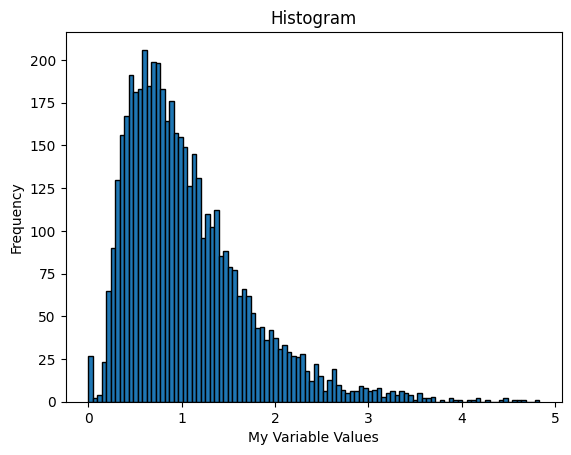

In [29]:
plt.hist(my_variable_view, bins=100, edgecolor='black')

# Adding labels and title
plt.xlabel('My Variable Values')
plt.ylabel('Frequency')
plt.title('Histogram')

# Displaying the histogram
plt.show()